# Quantum Fourier Transform

The discrete Fourier transform is defined as
$$ y_k = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} x_j \omega_N^{jk} $$
where $\omega_N^{jk} = e^{2 \pi i \frac{jk}{N}}$.

We can tranform this to a quantum algorithm by instead considering the transform on the state $\ket{X} = \sum_{j=0}^{N-1} x_j \ket{j} $, yielding the output state $\ket{Y} = \sum_{k=0}^{N-1} y_k \ket{k}$. This corresponds to the unitary matrix
$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{jk} \ket{k} \bra{j} $$

## Quantum Solution

<p align="center"><img src="images/quantum-fourier-transform-circuit.png"/></p>

The quantum Fourier transform uses two gates, the Hadamard gate and a two-qubit controlled rotation gate, defined by
$$ \text{CROT}_k = \begin{bmatrix} 1 & 0 \\ 0 & \text{UROT}_k \end{bmatrix} $$
where
$$ \text{UROT}_k = \begin{bmatrix} 1 & 0 \\ 0 & \exp{\left( \frac{2 \pi i}{2^k} \right)} \end{bmatrix} $$

The algorithm works by
1. Applying a Hadamard to the first qubit, yielding
$$ H_1 \ket{x_1 x_2 ... x_n} = \frac{1}{\sqrt{2}} \left[ \ket{0} + \exp \left( \frac{2 \pi i}{2} x_1 \right) \ket{1} \right] \otimes \ket{x_2 x_3 ... x_n} $$

2. Applying a $\text{UROT}_2$ with the first qubit as control and the second as the target, this results in the state
$$ \frac{1}{\sqrt{2}} \left[ \ket{0} + \exp \left( \frac{2 \pi i}{2^2} x_2 + \frac{2 \pi i}{2} x_1 \right) \ket{1} \right] \otimes \ket{x_2 x_3 ... x_n} $$

3. We then apply this $\text{UROT}_k$ gate to each qubit (controlled always by the first) up to the nth, yielding
$$ \frac{1}{\sqrt{2}} \left[ \ket{0} + \exp \left( \frac{2 \pi i}{2^{n}} x_{n} + \frac{2 \pi i}{2^{n-1}} x_{n-1} + ... + \frac{2 \pi i}{2^2} x_2 + \frac{2 \pi i}{2} x_1 \right) \ket{1} \right] \otimes \ket{x_2 x_3 ... x_n} $$

by defining $ x = 2^{n-1} x_1 + 2^{n-2} x_2 + ... + 2^1 x_{n-1} + 2^0 x_{n} $ we can rewrite this state as
$$ \frac{1}{\sqrt{2}} \left[ \ket{0} + \exp \left( \frac{2 \pi i}{2^n} x \right) \ket{1} \right] \otimes \ket{x_2 x_3 ... x_n} $$

4. This process is then repeated from steps 1-3, with instead the 2nd qubit as the control, resulting in the state
$$ \frac{1}{\sqrt{2}} \left[ \ket{0} + \exp \left( \frac{2 \pi i}{2^{n}} x \right) \ket{1} \right] \otimes \frac{1}{\sqrt{2}} \left[ \ket{0} + \exp \left( \frac{2 \pi i}{2^{n-1}} x \right) \ket{1} \right] \otimes ... \otimes \frac{1}{\sqrt{2}} \left[ \ket{0} + \exp \left( \frac{2 \pi i}{2^2} x \right) \ket{1} \right] \otimes \frac{1}{\sqrt{2}} \left[ \ket{0} + \exp \left( \frac{2 \pi i}{2} x \right) \ket{1} \right] $$

> Note that the qubit indexes of the QFT here is reversed wrt to the first definition

## Qiskit Implementation

In [1]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

In [2]:
qc = QuantumCircuit(3)

In [3]:
qc.h(2)
qc.draw()

q_0: ─────
          
q_1: ─────
     ┌───┐
q_2: ┤ H ├
     └───┘

In [4]:
qc.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2
qc.draw()

q_0: ──────────────
                   
q_1: ──────■───────
     ┌───┐ │P(π/2) 
q_2: ┤ H ├─■───────
     └───┘

In [5]:
qc.cp(pi/4, 0, 2) # CROT from qubit 2 to qubit 0
qc.draw()

q_0: ───────────────■───────
                    │       
q_1: ──────■────────┼───────
     ┌───┐ │P(π/2)  │P(π/4) 
q_2: ┤ H ├─■────────■───────
     └───┘

In [6]:
qc.h(1)
qc.cp(pi/2, 0, 1) # CROT from qubit 0 to qubit 1
qc.h(0)
qc.draw()

┌───┐
q_0: ───────────────■─────────────■───────┤ H ├
                    │       ┌───┐ │P(π/2) └───┘
q_1: ──────■────────┼───────┤ H ├─■────────────
     ┌───┐ │P(π/2)  │P(π/4) └───┘              
q_2: ┤ H ├─■────────■──────────────────────────
     └───┘

In [7]:
qc.swap(0,2)
qc.draw()

┌───┐   
q_0: ───────────────■─────────────■───────┤ H ├─X─
                    │       ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────■────────┼───────┤ H ├─■─────────────┼─
     ┌───┐ │P(π/2)  │P(π/4) └───┘               │ 
q_2: ┤ H ├─■────────■───────────────────────────X─
     └───┘

In [8]:
def qft_rotations(circuit, n):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1 # Indexes start from 0
    circuit.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit, we need to do a
        # smaller-angled controlled rotation: 
        circuit.cp(pi/2**(n-qubit), qubit, n)

In [9]:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

q_0: ──────■─────────────────────────
           │                         
q_1: ──────┼────────■────────────────
           │        │                
q_2: ──────┼────────┼────────■───────
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) 
q_3: ┤ H ├─■────────■────────■───────
     └───┘

In [10]:
from qiskit_textbook.widgets import scalable_circuit
scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xfb\x00\x00\x01\x08\x08\x06\x00\x00\x00X\x8d]e\x…

In [11]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

# Let's see how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

┌───┐
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├
           │                               │                ┌───┐ │P(π/2) └───┘
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■────────────
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘              
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■──────────────────────────
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                     
q_3: ┤ H ├─■────────■────────■─────────────────────────────────────────────────
     └───┘

In [12]:
scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x19\x00\x00\x01\x08\x08\x06\x00\x00\x00\x1a\xcd,…

In [14]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw()

┌───┐»
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├»
           │                               │                ┌───┐ │P(π/2) └───┘»
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■─────────X──»
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘           │  »
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■───────────────────────X──»
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                     »
q_3: ┤ H ├─■────────■────────■─────────────────────────────────────────────────»
     └───┘                                                                     »
«        
«q_0: ─X─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─┼─
«      │ 
«q_3: ─X─
«

In [15]:
scalable_circuit(qft)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04U\x00\x00\x01\x08\x08\x06\x00\x00\x00\x9eK\xcbE\x…

In [16]:
bin(5)

'0b101'

In [17]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state 5
qc.x(0)
qc.x(2)
qc.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


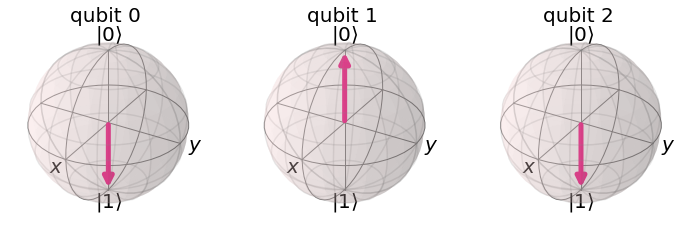

In [18]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

In [19]:
qft(qc,3)
qc.draw()

┌───┐                                     ┌───┐   
q_0: ┤ X ├──────■──────────────────────■───────┤ H ├─X─
     └───┘      │                ┌───┐ │P(π/2) └───┘ │ 
q_1: ───────────┼────────■───────┤ H ├─■─────────────┼─
     ┌───┐┌───┐ │P(π/4)  │P(π/2) └───┘               │ 
q_2: ┤ X ├┤ H ├─■────────■───────────────────────────X─
     └───┘└───┘

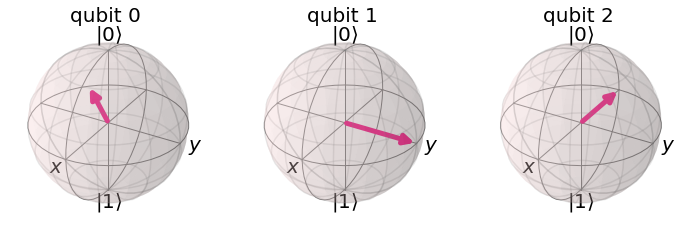

In [20]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)